# Bank Term Deposit Prediction

## 1. Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
import imblearn
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.feature_selection import chi2,SelectKBest
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.metrics import roc_curve,confusion_matrix
from xgboost import XGBClassifier
import pickle

## 2. Loading Data & Overview

In [2]:
data=pd.read_csv(r'E:\Downloads2\Bootcamp_Problem_Statement-master\data\new_train2.csv')
print(data.shape)

(32950, 14)


In [3]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,poutcome,y
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,nonexistent,no
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,failure,no
2,55,retired,married,basic.4y,no,no,no,cellular,jul,mon,550,1,nonexistent,yes
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,nonexistent,no
4,55,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,nonexistent,no


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32950 entries, 0 to 32949
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          32950 non-null  int64 
 1   job          32950 non-null  object
 2   marital      32950 non-null  object
 3   education    32950 non-null  object
 4   default      32950 non-null  object
 5   housing      32950 non-null  object
 6   loan         32950 non-null  object
 7   contact      32950 non-null  object
 8   month        32950 non-null  object
 9   day_of_week  32950 non-null  object
 10  duration     32950 non-null  int64 
 11  campaign     32950 non-null  int64 
 12  poutcome     32950 non-null  object
 13  y            32950 non-null  object
dtypes: int64(3), object(11)
memory usage: 3.5+ MB


###  a.checking for null values

In [5]:
data.columns.isnull().any()

False

### b.Distribution of classes & checking for imbalance

Text(0.5, 1.0, 'count of each class')

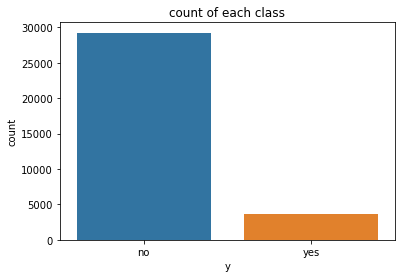

In [6]:
sns.countplot(data['y'])
plt.xlabel('y')
plt.title('count of each class')

In [7]:
classvalues=(data['y'].value_counts()/data['y'].value_counts().sum())*100
print(classvalues)

no     88.734446
yes    11.265554
Name: y, dtype: float64


### Observations : 
- There are no null values present. 
- The class distribution in the target is ~89:11. This is a clear indication of imbalance which will affect model perfomance badly by aligning with the majority class. This need to be treated properly. We will handle this as we move forward. 
- It is better if we convert classlabels to 0 & 1 from 'no'& 'yes' for further analysis & processing.

In [8]:
#encoding target
data.loc[data['y']=='no','y']=0
data.loc[data['y']=='yes','y']=1

## 3. Exploratory Data Analysis

###   Extracting Numerical & Categorical Features

In [9]:
numerical_features=list(set(data._get_numeric_data().columns)-{'y'})
numerical_features

['age', 'campaign', 'duration']

In [10]:
categorical_features=list(set(data.columns)-set(numerical_features)-{'y'}) #excluding numerical features & target variable from all columns
categorical_features

['default',
 'marital',
 'housing',
 'education',
 'poutcome',
 'loan',
 'job',
 'month',
 'day_of_week',
 'contact']

###  3.1.Univariate & Bivariate Analysis- Numerical features

In [11]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,32950.0,39.605584,9.079007,26.0,32.0,38.0,47.0,55.0
duration,32950.0,227.795357,158.757258,36.0,103.0,180.0,319.0,550.0
campaign,32950.0,2.189469,1.362850,1.0,1.0,2.0,3.0,5.0


In [12]:
#age
print('80th percentile_duration:',np.percentile(data['age'],80))
print('85th percentile_duration:',np.percentile(data['age'],85))
print('90th percentile_duration:',np.percentile(data['age'],90))
print('95th percentile_duration:',np.percentile(data['age'],95))
print('99th percentile_duration:',np.percentile(data['age'],99))

80th percentile_duration: 49.0
85th percentile_duration: 52.0
90th percentile_duration: 55.0
95th percentile_duration: 55.0
99th percentile_duration: 55.0


In [13]:
#duration
#converting call duration to minutes, for simpicity.
data['duration_mins']=data['duration'].apply(lambda x:np.round(x/60,2).round(2))

In [14]:
data['duration_mins'].describe()

count    32950.000000
mean         3.796943
std          2.646615
min          0.600000
25%          1.720000
50%          3.000000
75%          5.320000
max          9.170000
Name: duration_mins, dtype: float64

In [15]:
print('80th percentile_duration:',np.percentile(data['duration_mins'],80))
print('85th percentile_duration:',np.percentile(data['duration_mins'],85))
print('90th percentile_duration:',np.percentile(data['duration_mins'],90))
print('95th percentile_duration:',np.percentile(data['duration_mins'],95))
print('99th percentile_duration:',np.percentile(data['duration_mins'],99))

80th percentile_duration: 6.15
85th percentile_duration: 7.299999999999999
90th percentile_duration: 9.17
95th percentile_duration: 9.17
99th percentile_duration: 9.17


In [16]:
print('80th percentile_duration:',np.percentile(data['duration'],80))
print('85th percentile_duration:',np.percentile(data['duration'],85))
print('90th percentile_duration:',np.percentile(data['duration'],90))
print('95th percentile_duration:',np.percentile(data['duration'],95))
print('99th percentile_duration:',np.percentile(data['duration'],99))

80th percentile_duration: 369.0
85th percentile_duration: 438.0
90th percentile_duration: 550.0
95th percentile_duration: 550.0
99th percentile_duration: 550.0


### Observations
Age:
- Mean age of targeted customers is 39 and median is 38, which indicates this feature may be normally distibuted. Age range of targeted customers is 26-55, in which 50% lies in range 32-47. This shows that our previous campaigns are targeted mainly youngsters.
- 25% of customers are between age range 47-55 & 90=99th pecentiles are found to be 55,implies there are lot of people of age 55. Large no. of one particular age could be some errors or outliers. Further analysis will reveal more clear picture.

duration:
- Again, mean and median of the call duration feature are almost close,~3-4mins. 25% of the calls are of short duration , same % of calls are of duration 5-9 mins. This feature also seem to be normal distrbution upto 75 percentile, after that lot of long duration calls are there. 9-10 mins calls can happen, but almost 10% of the calls are of same no. secs could be alarming of outliers, as we saw in age feature. We will see the significance of this feature in prediction in further analysis.

campaign:
- Majority of the customers are contacted <=3 times. 1/4th of them are contacted 3-5 times.No. of calls could be a good indicator of our prediction.


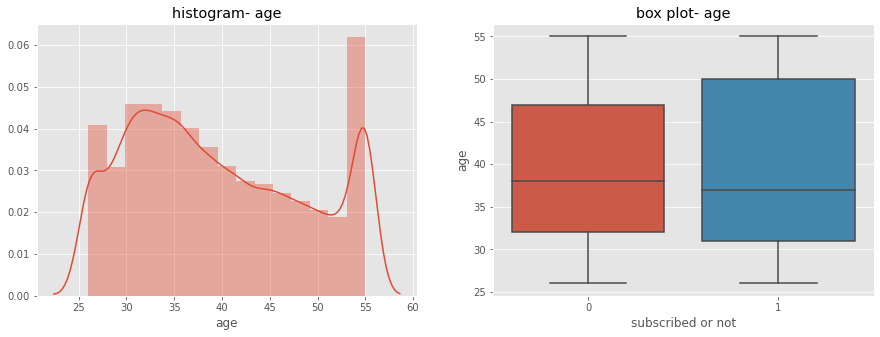

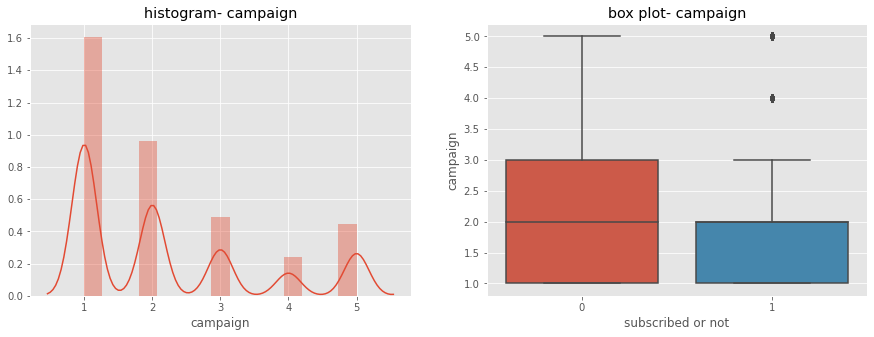

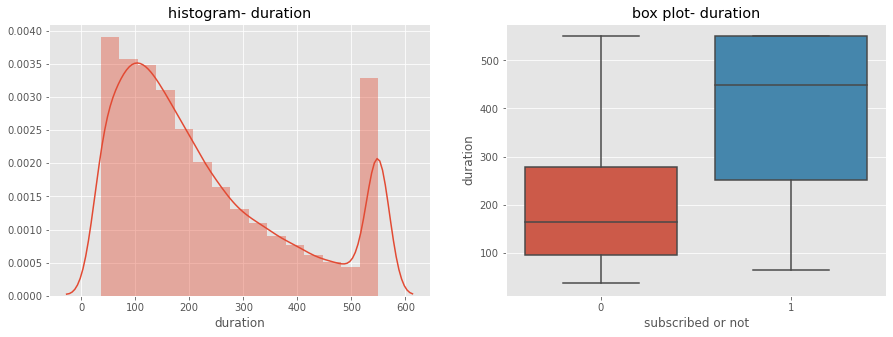

In [17]:
plt.style.use('ggplot')
for f in numerical_features:
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    sns.distplot(data[f],bins=15)
    plt.title('histogram- '+f)
    plt.xlabel(f)
    plt.subplot(122)
    sns.boxplot(x='y',y=f,data=data)
    plt.title('box plot- '+f )
    plt.xlabel('subscribed or not')
    plt.ylabel(f)
    

###  Observations:
- As we expected majority of the customers are of age 55 & all of them have subscribed for the term deposit.
- all customers above age 47 are subscribers of term deposit
- 50% of the calls are of duration are of <200 secs while similar no of longer duration calls (>500 secs) are also observed.
- call duration gives a good distinction between subscribers and non subscribers. All calls of duration >300 secs shows interest of customers and ended up in subscription of term deposit.
- most of the customers are contacted once in a campaign.
- Surprisingly, customers those are contacted lesser times have became subscribers of the term deposit plan.Whenever bank have to contact the customer more than 2 times, they ended up in not subscribing the term deposit. So it would be better for banks to decide to limit no.of contacts to 2-3.


In [18]:
data[data['age']==55].shape

(3388, 15)

In [19]:
data[data['duration']==550].shape

(3296, 15)

In [20]:
data[(data['age']==55)&(data['duration']==550)].shape

(340, 15)

- ~10% of customers are of age 55. Also 10% of calls are of duration exactly 550 sec. But there is not much overlapping between these datapoints.May be this is because all 55+ aged people were recorded under this catgory & all 550+ sec duration calls were recorded as 550 sec duration.
- Anyway all of the  subscribed customers had calls of higher duration but there are also few customers who didnt suscribed even after long conversation. Also there are very few people who have not subscribed & falls under age range >=55.

###  3.2.Univariate Analysis- categorical features

### 3.2.a. Marital

In [21]:
def plot_categorical(feature):
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    sns.countplot(y=data[feature],palette='inferno_r')
    plt.title(feature)
    plt.show()
    

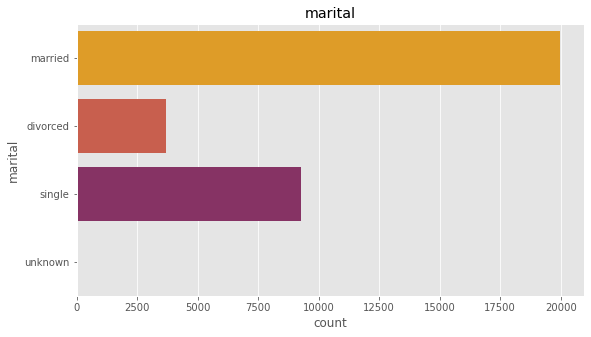

In [22]:
plot_categorical('marital')

* Observations:
- Majority of our listed customers are married. Also there are pretty good no. of single people and lesser no. of divorcees.
- Our bank is targetting married people more because they seem to be more interested in Saving.
- As we have seen earlier, our customers are of age>25, and most of the single people will be of age range 25-30. They could  also be interestd in investing in term deposits because this is the age when they start earning & majority of them prefer low-risk bank deposits rather than share-market or mutual fund as they lack experience in them.
- let us examine this more closely as we move further.
- There are also some unknown values in this feature.

### 3.2.b.Day of week

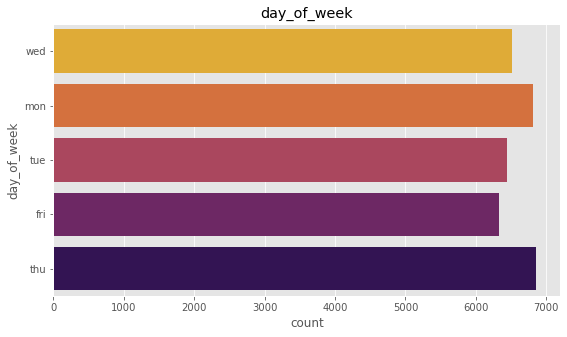

In [23]:
plot_categorical('day_of_week')

* Observations:
- Bank has contacted her customers on all weekdays almost uniformly. Seems this feature won't help us much.


### 3.2.c.month

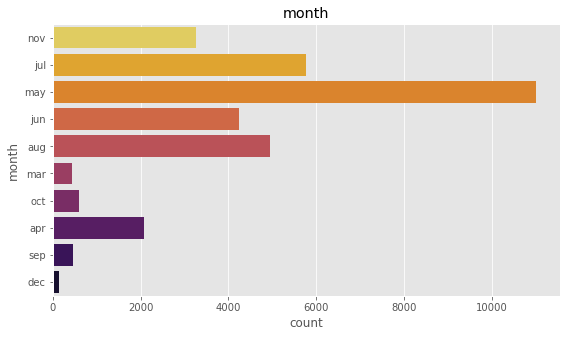

In [24]:
plot_categorical('month')

* Month- Observations:
- Large no. of contacts are done in the month of May. 4000-6000 people are contacted in months June,July,August. After that there is a decline in no. of contacts per month. This may be because of the end of the previous campaign.
- November also shows good no. of contacts.
- Two months data(Jan,Feb)is missing. In real world sense, we need to collect more data because the missing months are needed if this is an important feature. With more analysis we will decide whether to keep this feature or drop it.


### 3.2.c.Housing

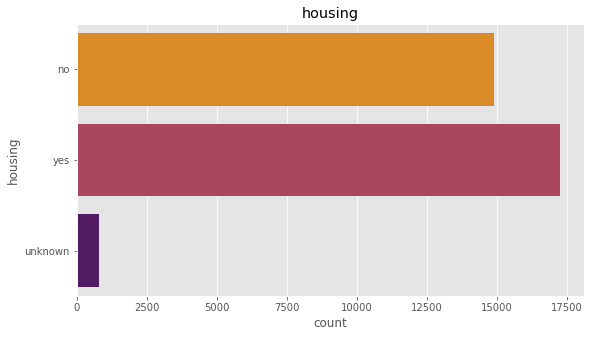

In [25]:
plot_categorical('housing')

* Housing- Observations:
- Customers having housing loan are more in no. than customers those who don't have one.
- This feature also have some unknown values, which is needed to be treated.


### 3.2.d.Default

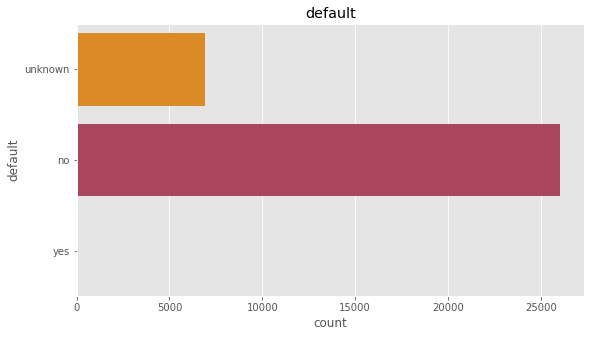

In [26]:
plot_categorical('default')

* Default-Observations:
- Most of the customers don't have default.
- There are very few customers were recorded as having a default and many were recorded as unknown.
- Since there are many unknown values, instead of dropping them we will just keep it as a seperate category because some people may not be willing to reveal this information and thus became 'unknown' category.


### 3.2.e.Education

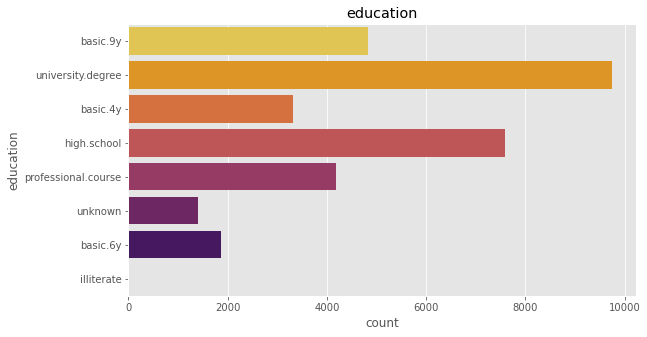

In [27]:
plot_categorical('education')

* Education- Observations:
- Education Could play an important role in term deposit subscription explicitely or implicitely. 
- Most of our customers are having a university degree or high school grade education.
- Here our hypothesis is Highly educated people will be having good job and high salary, hence they might  subscribe to term deposit plan. On other hand, there is a possibility that educated people are ready to invest in high risk-high income investments like share market/mutual funds, so they pefer such plans over bank deposit. We will clarify approach of educated people towards bank deposits in further analysis.


### 3.2.f.Job

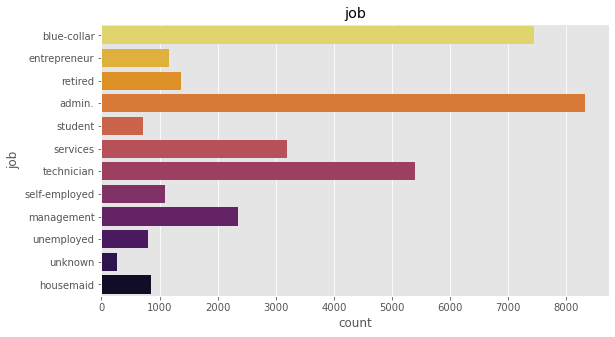

In [28]:
plot_categorical('job')

* Job- Observations:
- Similar to education, we expect high salaried people will be interested in investments. But there other investment plans for them to choose from. we will see how they respond to bank deposits.
- Our bank is targeting more in people in jobs like admin,bluecollar jobs.
- Bank should target high salaried people.


### 3.2.g.Loan

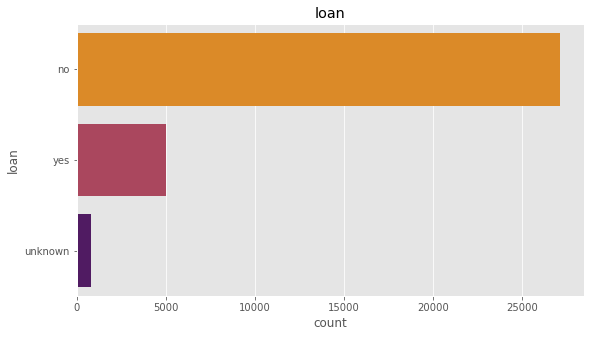

In [29]:
plot_categorical('loan')

* Loan-Observations:
- Most of our customers have no loans. It is a good idea to target these people.
- There exists some unknown values also.



### 3.2.h.Contact

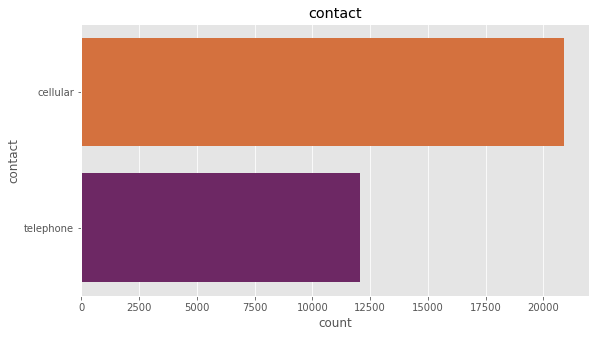

In [30]:
plot_categorical('contact')

* Contact- Observations:
- most people prefer cellular mode of communication than telephone, as it is convenient.
- Despite this decent no. of people uses Telephone.
- It doesn't seem to be a good predictor.


### 3.2.i.Poutcome

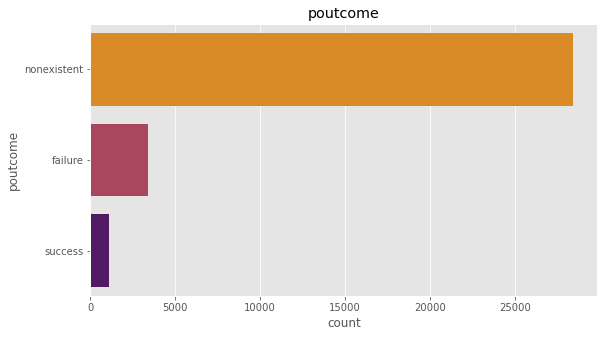

In [31]:
plot_categorical('poutcome')

- Bank is focusing more on people who are new to campaign where previous campaign data is non-exisistent, which seems to be a good attempt.
- Bank is also retrying with people who were part of previous campaigns, more on failed ones & lesser on successful one. There might be chances of getting subscribers from  these categories, but lesser.Still it is worth trying.


### 3.3.Bivariate analysis- Categorical Features

In [32]:
def print_percentage(ax,no_categories):
    pos_list=[]
    neg_list=[]
    for i in range(no_categories):
        total=ax.patches[i].get_height()+ax.patches[i+no_categories].get_height()
        pos_percent_=round(((ax.patches[i+no_categories].get_height()/total)*100),2)
        neg_percent_=round(((ax.patches[i].get_height()/total)*100),2)
        pos_list.append(pos_percent_)
        neg_list.append(neg_percent_)
    return (pos_list,neg_list)

In [33]:
def plot_feature_withhue(feature):
    plt.figure(figsize=(30,6))
    plt.subplot(121)
    ax=sns.countplot(x=data[feature],hue=data['y'],palette=['red','green'])
    no_categories=len(ax.patches)//2
    p,n=print_percentage(ax,no_categories)
    for num in range(no_categories):
        p_=p[num]
        n_=n[num]
        yn=ax.patches[num].get_height()+125
        yp=ax.patches[num+no_categories].get_height()+125
        plt.text(num-0.35,yn,'{}%'.format(round(n_,2)),fontsize='large')
        plt.text(num+0.05,yp,'{}%'.format(round(p_,2)),fontsize='large')
        plt.title(feature+' v/s subscribed or not')
    plt.show()
    print(' ******* percentage(%)values shown are percentage of customers subscribed & didn\'t subscribe under each category*******')
    print('='*120)

### 3.3.a. Marital v/s Target

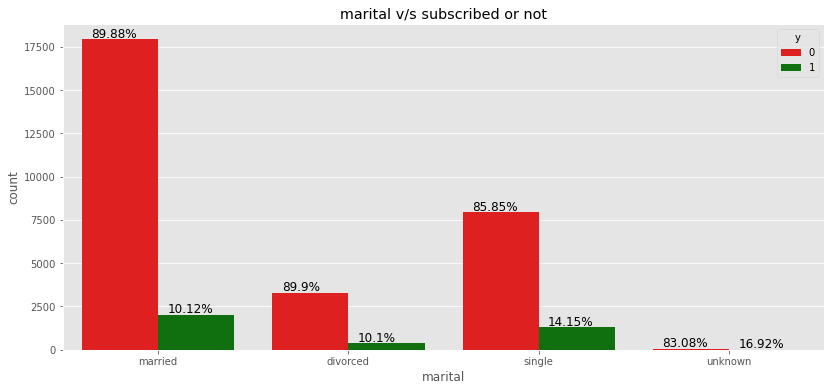

 ******* percentage(%)values shown are percentage of customers subscribed & didn't subscribe under each category*******


In [34]:
plot_feature_withhue('marital')

* marital v/s Subscription:
- As we have seen majority of our customers are married.~10% of married people have subscribed for term deposit.
- It s clear that 14% of single people have subscribed to term deposit, but they are less in number as no. of single people contacted by bank is only half the no. of married people.
- This shows interest of single customers in investments, as we expected. Majority of Single people would be of age 25-32.Let us analyse more.


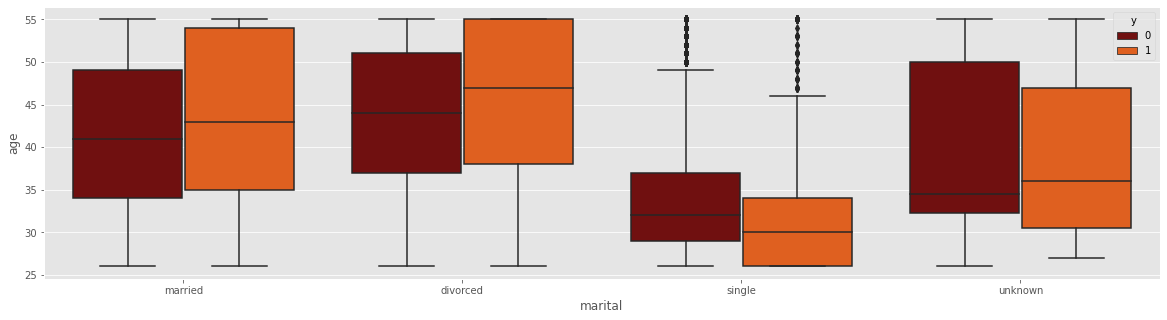

In [35]:
plt.figure(figsize=(20,5))
sns.boxplot(x='marital',y='age',hue='y',data=data,palette='gist_heat')

- most of the married people above 50 are intersted in converting to term deposit subscribers.
- Divorcees above >50 also shows similar interest
- As expected most of the single people who subscribed are of age <34 & almost all of single people in age range 25-29 have been coverted to subscribers. 
- It is a good idea that bank should target these categories, especially younger & single more in future campaigns.

### 3.3.b. Day of week v/s Target

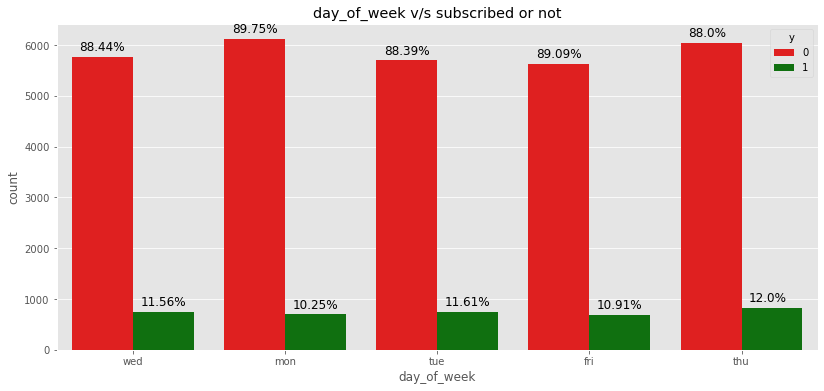

 ******* percentage(%)values shown are percentage of customers subscribed & didn't subscribe under each category*******


In [36]:
plot_feature_withhue('day_of_week')

- All working days of week shows similar trend.
- All working days of week have contributed ~10% of subscribers from targeted customers.
- More no. of contacts with optimum type of customers will result in more subscribers.

### 3.3.c. Month v/s Target

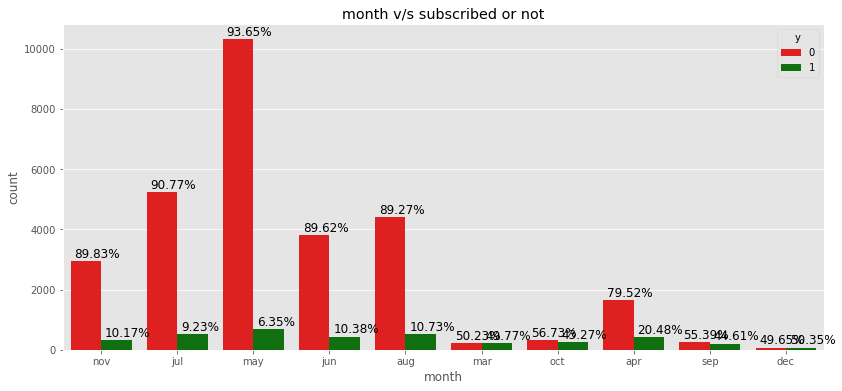

 ******* percentage(%)values shown are percentage of customers subscribed & didn't subscribe under each category*******


In [37]:
plot_feature_withhue('month')

- Higher no. of customers are contacted & higher no.of customers had subscribed in the month of may. But this is not in proportion with no. of customers contacted.It forms only 6.35%. 
- June,July,August,November are months on those bank has actively contacted customers & ~10% of customers have been converted in these months.
- In March,April,September,October,december months bank had contacted lesser customers but good percentage (~50%)of them have been converted.
- Targetting more no. optimum customers with highest probability of conversion could improve no. of subscriptions.

In [38]:
### 3.3.d. Housing Loan v/s Target

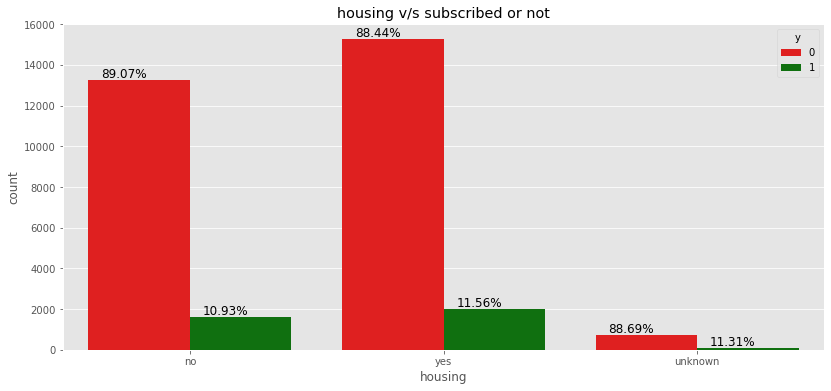

 ******* percentage(%)values shown are percentage of customers subscribed & didn't subscribe under each category*******


In [39]:
plot_feature_withhue('housing')

- More customers are having housing loan & category of such customers are having more no of subscribers. But this is not a huge difference. Both categories behaves in almost similar manner. 

### 3.3.e. Default v/s Target

posx and posy should be finite values
posx and posy should be finite values


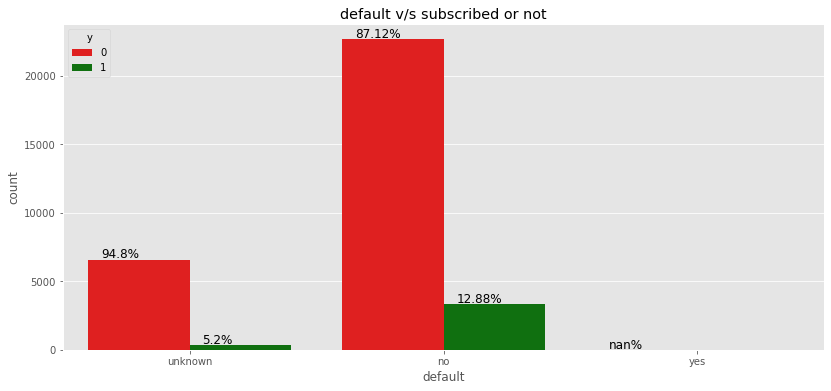

 ******* percentage(%)values shown are percentage of customers subscribed & didn't subscribe under each category*******


In [40]:
plot_feature_withhue('default')

- default feature is ambigous in our data. There are very few people were recorded to be having default. Also there are large no. of unknown values, of which 5.2% were coverted to subscribers.
- Anyway Majority of our customers are not having default & 12.88% of them have subscribed to term deposit.

### 3.3.c. Loan v/s Target

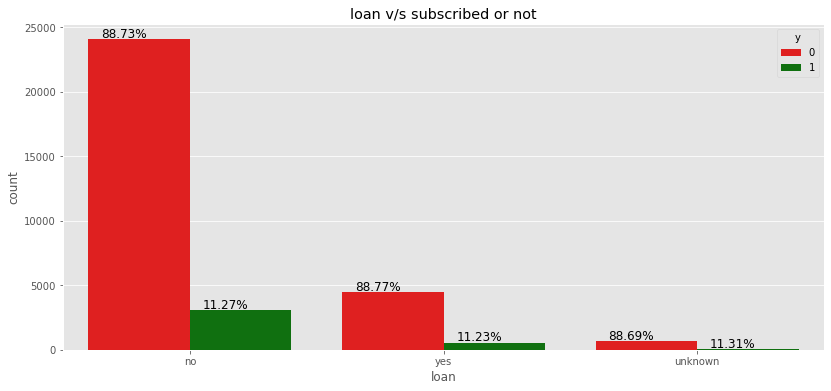

 ******* percentage(%)values shown are percentage of customers subscribed & didn't subscribe under each category*******


In [41]:
plot_feature_withhue('loan')

- Majority of our customers are not having a personal loan. Despite having or not having a loan, similar percentage of customers have subscribed to term deposit.
- So customers should not be avoided even if they are having personal loan.

### 3.3.d. Education v/s Target

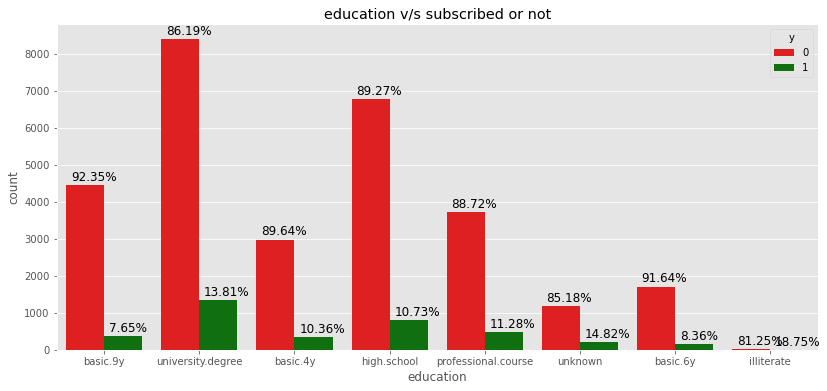

 ******* percentage(%)values shown are percentage of customers subscribed & didn't subscribe under each category*******


In [42]:
plot_feature_withhue('education')

- Most of our customers are having a university degree or high school grade education. Percentage of customers who are converted to subscribers of term deposit is higher for people having university degree, professional course & high school education,as expected.
- No. of customers bank contacted for deposit having lower qualifications is also lower, but these categories also contributes to subscription. So Education can not distinguish subscription classes sharply.

### 3.3.e. Job v/s Target

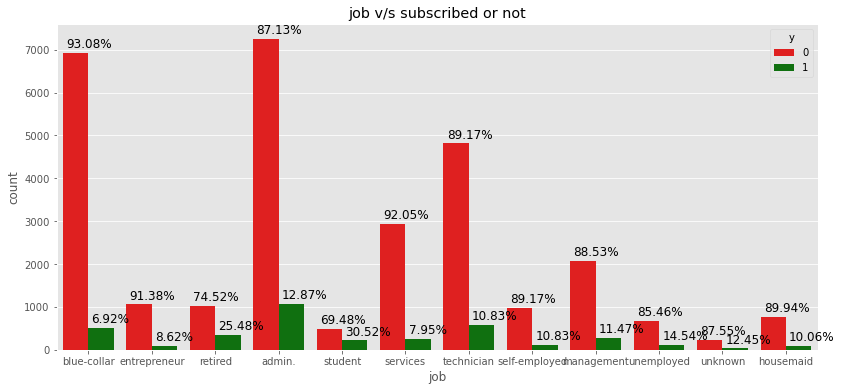

 ******* percentage(%)values shown are percentage of customers subscribed & didn't subscribe under each category*******


In [43]:
plot_feature_withhue('job')

- Bank have most of the customers in admin,blue-collar & technician jobs  and subscription in these categories are higher in number  as compared with other categories.
- But when we compare the percentages, these higher count is contributed by only 12.87% of total customers, for admin job ,10.83% for technician jobs and 6.92% for blue-collar jobs.
- A significant percentage of retired people(25.48%) and student(30.52%) have subscribed to term deposit which implies more focus to be given to these categories. 
- All other categories are responding at almost uniform rate. Bank has focused more on blue-collar jobs previously,but response is very poor. Responses of customers who are self-employed & having management jobs are much better.

### 3.3.f Contact v/s Target

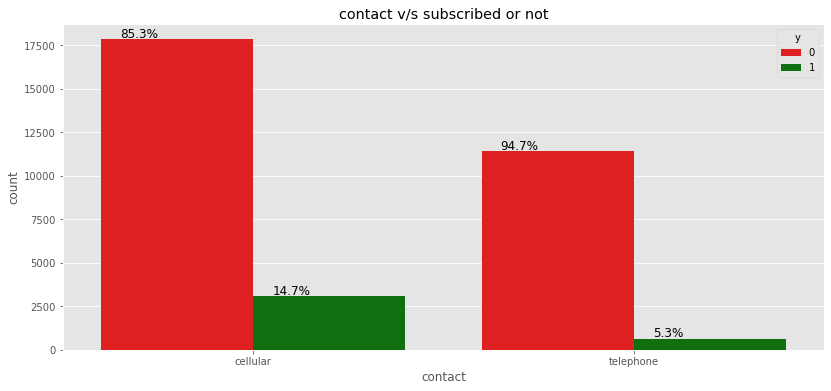

 ******* percentage(%)values shown are percentage of customers subscribed & didn't subscribe under each category*******


In [44]:
plot_feature_withhue('contact')

### 3.3.g. Poutcome v/s Target

-  percentage of cellular users converted are more than that of telephone users.

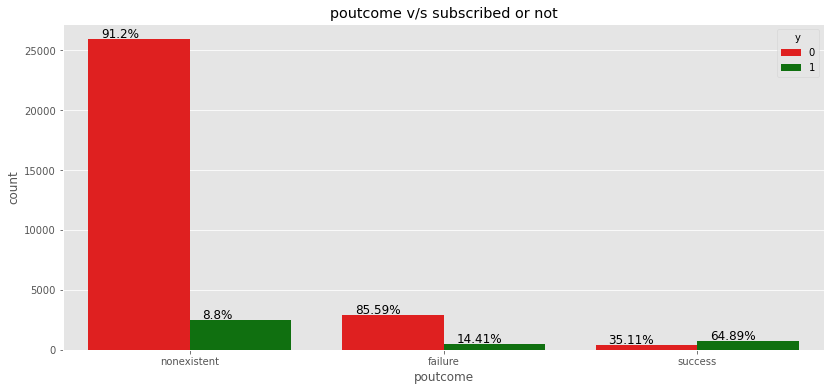

 ******* percentage(%)values shown are percentage of customers subscribed & didn't subscribe under each category*******


In [45]:
plot_feature_withhue('poutcome')

- 8.8 % of customers who are new to the campaign are converted to term deposit subscribers.
- Reattempting for customers who were already targeted in previous campaigns is highly encouraged,seeing that 64.85% of customers from previous successful campaigns have been converted. Also 14.41% of customers those who didn't subscribed in previous campaigns did subscribe in this campaign.

## 3.4.Making Data Model-Ready:Preprocessing

### 3.4.1.Treating Unknown values.

- There are some unknown values in some categories: default,marital,housing,loan,job,education.
- These are to be treated properly.

In [46]:
#unknown values in each category
print(data[data['loan']=='unknown'].shape)
print(data[data['housing']=='unknown'].shape)
print(data[data['default']=='unknown'].shape)
print(data[data['marital']=='unknown'].shape)

(796, 15)
(796, 15)
(6940, 15)
(65, 15)


In [47]:
data[(data['loan']=='unknown')&(data['housing']=='unknown')].shape

(796, 15)

- no. unknown values :
- 'education': 1397 : education is directly related to job.so we can infer education from jobs. Here we impute each 'unknown' values in 'education' field  with mode of 'education' of those datapoints recorded with jobs=job of given datapoint.    
- 'job': 265 : Same approach as of imputing education fields is followed here as job can be inferred from education.Also wherever job='unknown& age>60, we infer job as 'retired'.
- 'marital': 65 : very few no., dropping these rows
- 'default': 6940: large no. of data points. dropping will cause loss of information. keeping this as a seperate category named 'not_disclosed'
- 'housing': 796, 'loan': 796: Same no. of unknown values & these are in same rows. since 2 features are missing, we will drop those rows.


### a. Education

In [48]:
print("before imputation:")
print("="*20)
print("unknown values in education:",data[data['loan']=='unknown'].shape[0])


before imputation:
unknown values in education: 796


In [49]:
#infering education from job #cross tabulation of job & education
job_edu_tab=pd.crosstab(data['job'],data['education'])
job_edu_tab

education,basic.4y,basic.6y,basic.9y,high.school,illiterate,professional.course,university.degree,unknown
job,,,,,,,,
admin.,61,122,390,2651,0,290,4606,194
blue-collar,1849,1162,2901,710,8,359,78,374
entrepreneur,101,56,166,190,2,109,485,51
housemaid,374,68,72,139,1,49,118,34
management,82,68,130,236,0,71,1670,88
retired,468,53,118,216,2,200,237,72
self-employed,75,20,165,97,3,132,585,22
services,110,182,317,2162,0,169,131,125
student,17,12,80,284,0,34,139,145


In [50]:
#imputing unknowns in education with mode of education in each job category 
jobs_list=list(data.job.value_counts().index)
for jobs in jobs_list:
    edu_mode=data.loc[(data['job']==jobs)&(data['education']!='unknown')]['education'].mode()[0]
    data.loc[(data['job']==jobs)& (data['education']=='unknown'),'education']=edu_mode


In [51]:
print("after imputation:")
print("="*20)
print("unknown values in education:",data[data['loan']=='unknown'].shape[0])


after imputation:
unknown values in education: 796


### b. Job

In [52]:
# job categories and counts:
print("after imputation:")
print("="*20)
print("unknown values in job:",data[data['job']=='unknown'].shape[0])


after imputation:
unknown values in job: 265


In [53]:
# imputing unknown values in job #infering from age #infering from education.
data.loc[(data['age']>60)&(data['job']=='unknown'),'job']='retired' #if age>60, infer job as 'retired'
#imputing unknowns in education with mode of education in each job category 
edu_list=list(data.education.value_counts().index)
for edu in edu_list:
    job_mode=data.loc[(data['education']==edu)&(data['job']!='unknown')]['job'].mode()[0]
    data.loc[(data['education']==edu)&(data['job']=='unknown'),'job']=job_mode

In [54]:
print("after imputation:")
print("="*20)
print("unknown values in job:",data[data['job']=='unknown'].shape[0])


after imputation:
unknown values in job: 0


### c. Loan,Housing & Marital

In [55]:
print("before imputation:")
print("="*20)
print("unknown values in loan:",data[data['loan']=='unknown'].shape[0])
print("unknown values in housing:",data[data['housing']=='unknown'].shape[0])
print("unknown values in marital:",data[data['marital']=='unknown'].shape[0])

before imputation:
unknown values in loan: 796
unknown values in housing: 796
unknown values in marital: 65


In [56]:
#as there are datapoints having unknowns in multiple columns(loan,housing),dropping those indices.
data.drop(data[(data['loan']=='unknown')&(data['housing']=='unknown')].index,inplace=True)
#there are few unknowns in maritals,just dropping them.
data.drop(data[(data['marital']=='unknown')].index,inplace=True)


In [57]:
print("after imputation:")
print("="*20)
print("unknown values in loan:",data[data['loan']=='unknown'].shape[0])
print("unknown values in housing:",data[data['housing']=='unknown'].shape[0])
print("unknown values in marital:",data[data['marital']=='unknown'].shape[0])

after imputation:
unknown values in loan: 0
unknown values in housing: 0
unknown values in marital: 0


### d. Default

In [58]:
print("before imputation:")
print("="*20)
print("unknown values in default:",data[data['default']=='unknown'].shape[0])

before imputation:
unknown values in default: 6752


- Almost 20% datapoints have default status as unknown.Treat it as another category named'not_disclosed'

In [59]:
data.loc[data['default']=='unknown','default']='not_disclosed'

In [60]:
print("after imputation:")
print("="*20)
print("unknown values in default:",data[data['default']=='unknown'].shape[0])

after imputation:
unknown values in default: 0


###  3.4.2.Splitting data into train & test

In [61]:
print(data.shape)
data.columns

(32090, 15)


Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'poutcome',
       'y', 'duration_mins'],
      dtype='object')

In [62]:
y=data['y'].values
y=y.astype('b')
x=data.drop(['y','day_of_week','duration_mins'],axis=1)
print(x.shape,y.shape)

(32090, 12) (32090,)


In [63]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,stratify=y)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(25672, 12) (25672,)
(6418, 12) (6418,)


### 3.4.3. Encoding Categorical features

In [64]:
print("categorical features are:")
print("="*30)
print(set(categorical_features)-{'day_of_week'})

categorical features are:
{'default', 'marital', 'housing', 'poutcome', 'education', 'loan', 'job', 'month', 'contact'}


In [65]:
print('Education categories:')
print(data.education.value_counts())
print('='*30)
print('Job :')
print(data.job.value_counts())



Education categories:
university.degree      9852
high.school            7668
basic.9y               5058
professional.course    4265
basic.4y               3417
basic.6y               1814
illiterate               16
Name: education, dtype: int64
Job :
admin.           8184
blue-collar      7416
technician       5278
services         3111
management       2285
retired          1331
entrepreneur     1130
self-employed    1060
housemaid         828
unemployed        774
student           693
Name: job, dtype: int64


In [66]:
def encode(data):
    
    data.loc[data['education']=='illiterate','education']=0
    data.loc[data['education']=='basic.4y','education']=1
    data.loc[data['education']=='basic.6y','education']=2
    data.loc[data['education']=='basic.9y','education']=3
    data.loc[data['education']=='high.school','education']=4
    data.loc[data['education']=='professional.course','education']=5
    data.loc[data['education']=='university.degree','education']=6
    
    data.loc[data['job']=='student','job']=0
    data.loc[data['job']=='unemployed','job']=1
    data.loc[data['job']=='housemaid','job']=2
    data.loc[data['job']=='self-employed','job']=3
    data.loc[data['job']=='entrepreneur','job']=4
    data.loc[data['job']=='retired','job']=5
    data.loc[data['job']=='management','job']=6
    data.loc[data['job']=='services','job']=7
    data.loc[data['job']=='technician','job']=8
    data.loc[data['job']=='blue-collar','job']=9
    data.loc[data['job']=='admin.','job']=10
    
    data.loc[data['month']=='jan','month']=1
    data.loc[data['month']=='feb','month']=2
    data.loc[data['month']=='mar','month']=3
    data.loc[data['month']=='apr','month']=4
    data.loc[data['month']=='may','month']=5
    data.loc[data['month']=='jun','month']=6
    data.loc[data['month']=='jul','month']=7
    data.loc[data['month']=='aug','month']=8
    data.loc[data['month']=='sep','month']=9
    data.loc[data['month']=='oct','month']=10
    data.loc[data['month']=='nov','month']=11
    data.loc[data['month']=='dec','month']=12
    
    data.loc[data['default']=='yes','default']=-1
    data.loc[data['default']=='not_disclosed','default']=0
    data.loc[data['default']=='no','default']=1
    
    return data

In [67]:
def dummy_encode(data):
    columns=['loan','housing','poutcome','marital','contact']
    data=pd.get_dummies(data,columns=columns,drop_first=True)
    return data


In [68]:
#featureset-1
#encode train data 
x_train1=encode(x_train)#manual label encoding
x_train1=dummy_encode(x_train1) #dummy encoding
#encode test data
x_test1=encode(x_test)
x_test1=dummy_encode(x_test1)
print(x_train1.shape,x_test1.shape)

(25672, 14) (6418, 14)


In [69]:
missing_cols=set(x_train1.columns)-set(x_test1.columns)
for c in missing_cols:
    x_test1[c]=0
#Ensure order of columns in test data as same as train data & removing any new column in test dataset not present in train dataset
x_test1=x_test1[x_train1.columns]
print(x_train1.shape,x_test1.shape)

(25672, 14) (6418, 14)


In [70]:
print(list(x_train1.columns))
print(list(x_test1.columns))


['age', 'job', 'education', 'default', 'month', 'duration', 'campaign', 'loan_yes', 'housing_yes', 'poutcome_nonexistent', 'poutcome_success', 'marital_married', 'marital_single', 'contact_telephone']
['age', 'job', 'education', 'default', 'month', 'duration', 'campaign', 'loan_yes', 'housing_yes', 'poutcome_nonexistent', 'poutcome_success', 'marital_married', 'marital_single', 'contact_telephone']


In [71]:
#dummy encoding all features to make another featureset #featureset-2
x_train2=pd.get_dummies(x_train,drop_first=True)
x_test2=pd.get_dummies(x_test,drop_first=True)
print(x_train2.shape,x_test2.shape)

(25672, 37) (6418, 36)


In [72]:
missing_cols=set(x_train2.columns)-set(x_test2.columns)
for c in missing_cols:
    x_test2[c]=0
#Ensure order of columns in test data as same as train data & removing any new column in test dataset not present in train dataset
x_test2=x_test2[x_train2.columns]
print(x_train2.shape,x_test2.shape)

(25672, 37) (6418, 37)


In [73]:
print(list(x_train2.columns))
print(list(x_test2.columns))


['age', 'duration', 'campaign', 'job_1', 'job_2', 'job_3', 'job_4', 'job_5', 'job_6', 'job_7', 'job_8', 'job_9', 'job_10', 'marital_married', 'marital_single', 'education_1', 'education_2', 'education_3', 'education_4', 'education_5', 'education_6', 'default_0', 'default_1', 'housing_yes', 'loan_yes', 'contact_telephone', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'poutcome_nonexistent', 'poutcome_success']
['age', 'duration', 'campaign', 'job_1', 'job_2', 'job_3', 'job_4', 'job_5', 'job_6', 'job_7', 'job_8', 'job_9', 'job_10', 'marital_married', 'marital_single', 'education_1', 'education_2', 'education_3', 'education_4', 'education_5', 'education_6', 'default_0', 'default_1', 'housing_yes', 'loan_yes', 'contact_telephone', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'poutcome_nonexistent', 'poutcome_success']


### 3.4.4. Handling Class Imbalance (SMOTE)

In [74]:
#oversampling
oversample=SMOTE()
x_train_df1,y_train_df1=oversample.fit_resample(x_train1,y_train) #oversampling featureset1 training data
x_train_df2,y_train_df2=oversample.fit_resample(x_train2,y_train) #oversampling featureset2 training data
print(x_train_df1.shape,y_train_df1.shape)
print(x_train_df2.shape,y_train_df2.shape)

(45566, 14) (45566,)
(45566, 37) (45566,)


### 3.4.5.Feature Scaling

In [75]:
std=StandardScaler()
#featureset 1
x_train_std1=pd.DataFrame(std.fit_transform(x_train_df1),columns=x_train_df1.columns)
x_test_std1=pd.DataFrame(std.transform(x_test1),columns=x_test1.columns)
#featureset2
x_train_std2=pd.DataFrame(std.fit_transform(x_train_df2),columns=x_train_df2.columns)
x_test_std2=pd.DataFrame(std.transform(x_test2),columns=x_test2.columns)

In [76]:
#scaling features to range(0,1)
minmax=MinMaxScaler() 
#featureset1
x_train_m1=pd.DataFrame(minmax.fit_transform(x_train_df1),columns=x_train_df1.columns)
x_test_m1=pd.DataFrame(minmax.transform(x_test1),columns=x_test1.columns)
#featureset-2
x_train_m2=pd.DataFrame(minmax.fit_transform(x_train_df2),columns=x_train_df2.columns)
x_test_m2=pd.DataFrame(minmax.transform(x_test2),columns=x_test2.columns)

### 3.5. Hunt For Best Base Classification Supervised Learning Model

In [77]:
#Now let us define some useful functions
def fit_predict(model,x_train,y_train,x_test):
    '''' This function fits a model and returns predictions of test data'''
    model.fit(x_train,y_train)
    y_hat=model.predict(x_test)
    return(y_hat)

def draw_confusion_matrix(y,y_hat):
    '''drawing confusion matrix'''
    cm=confusion_matrix(y,y_hat)
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels = ['NO','YES'] , yticklabels = ['NO','YES'],cmap='Oranges' )
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title("CONFUSION_MATRIX_")
    plt.show()

def plot_roc(model,y_train,y_hat_train,y_test,y_hat_test):
    '''This function plots roc curve for given predictions'''
    #auc score
    auc_train=roc_auc_score(y_train,y_hat_train)
    auc_test=roc_auc_score(y_test,y_hat_test)

    #plot ROC curve:train & test
    fpr1,tpr1,threshold1=roc_curve(y_train,y_hat_train)
    fpr2,tpr2,threshold2=roc_curve(y_test,y_hat_test)    
    print("ROC_AUC_CURVE:",model)
    plt.plot(fpr1,tpr1,color='blue',label ='AUC = %0.2f' % auc_train)
    plt.plot(fpr2,tpr2,color='red',label ='AUC = %0.2f' % auc_test)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.legend()
    plt.show()
    print('TRAIN_ROC_AUC_SCORE is',auc_train)
    print('TEST_ROC_AUC_SCORE is',auc_test)
    print("="*60)
    return auc_train,auc_test

def roc_test(model,y,y_hat):
    auc=roc_auc_score(y,y_hat)
    fpr,tpr,threshold=roc_curve(y,y_hat)
    
    print("ROC_AUC_CURVE:",model)
    plt.plot(fpr,tpr,color='red',label ='AUC = %0.2f' % auc)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.legend()
    plt.show()
    print('ROC_AUC_SCORE is',auc)
    print("="*60)

def evaluate(model,y,y_hat):
    '''This function prints and returns various metrics: accuracy,precision,recall,f1 score & auc'''
    accuracy=accuracy_score(y,y_hat)
    recall=recall_score(y,y_hat)
    precision=precision_score(y,y_hat)
    f1=f1_score(y,y_hat)
    auc=roc_auc_score(y,y_hat)
    
    print(model.__class__.__name__)
    print("="*60)
    draw_confusion_matrix(y,y_hat)

    print("\nReport:")
    print("="*60)
    print("Accuracy:",accuracy)
    print("Recall:",recall)
    print("Precision:",precision)
    print("F1 Score",f1)
    print("auc",auc)
    print("\n"+"="*60)
    return [accuracy,precision,recall,f1,auc]

def get_metrics(model,y,y_hat):
    '''This function prints and returns various metrics: accuracy,precision,recall & f1 score'''
    
    accuracy=accuracy_score(y,y_hat)
    recall=recall_score(y,y_hat)
    precision=precision_score(y,y_hat)
    f1=f1_score(y,y_hat)
    
    #print(model.__class__.__name__)
    #print("="*60)
    #draw_confusion_matrix(y,y_hat)
    
    print("Accuracy:",accuracy)
    print("Recall:",recall)
    print("Precision:",precision)
    print("F1 Score",f1)
    print("\n"+"="*60)
    return [accuracy,precision,recall,f1]
    

In [79]:
#initializing  empty dictionarytwo store metric scores of different models.
scores=dict()


### 3.5.1.K-Nearest Neighbors

KNeighborsClassifier


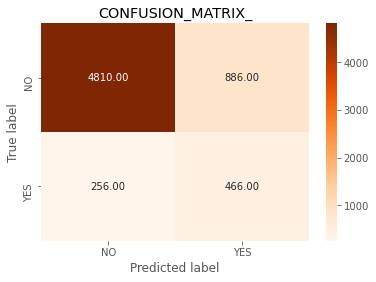


Report:
Accuracy: 0.8220629479588657
Recall: 0.6454293628808865
Precision: 0.34467455621301774
F1 Score 0.44937319189971064
auc 0.7449408050359488

ROC_AUC_CURVE: KNeighborsClassifier()


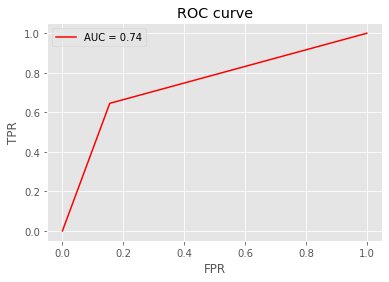

ROC_AUC_SCORE is 0.7449408050359488


In [213]:
knn=KNeighborsClassifier()
y_hat=fit_predict(knn,x_train_std1,y_train_df1,x_test_std1)
test=evaluate(knn,y_test,y_hat)
roc_test(knn,y_test,y_hat)
scores['knn']=test

### 3.5.2.Logistic Regression

LogisticRegression


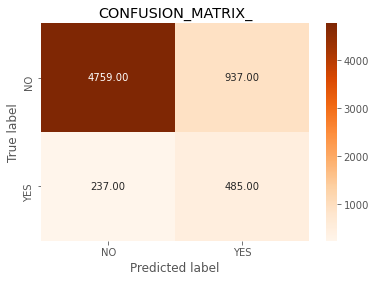


Report:
Accuracy: 0.817076971019009
Recall: 0.6717451523545707
Precision: 0.3410689170182841
F1 Score 0.45242537313432846
auc 0.7536218739300944

ROC_AUC_CURVE: LogisticRegression()


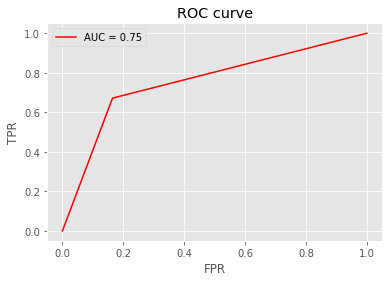

ROC_AUC_SCORE is 0.7536218739300944


In [208]:
logR=LogisticRegression()
y_hat=fit_predict(logR,x_train_std1,y_train_df1,x_test_std1)
test=evaluate(logR,y_test,y_hat)
roc_test(logR,y_test,y_hat)
scores['logR']=test

### 3.5.3.Support Vector Machines

SVC


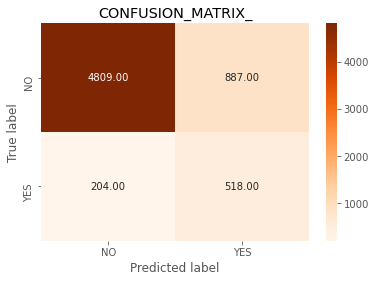


Report:
Accuracy: 0.8300093487067622
Recall: 0.7174515235457064
Precision: 0.3686832740213523
F1 Score 0.4870709920075223
auc 0.7808641044694824

ROC_AUC_CURVE: SVC()


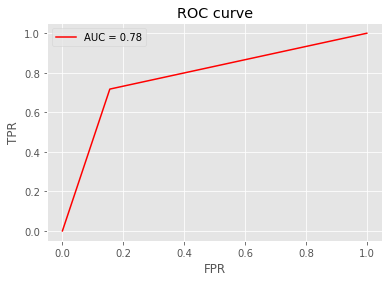

ROC_AUC_SCORE is 0.7808641044694824


In [209]:
svm=SVC()
y_hat=fit_predict(svm,x_train_std1,y_train_df1,x_test_std1)
test=evaluate(svm,y_test,y_hat)
roc_test(svm,y_test,y_hat)
scores['svm']=test

### 3.5.4.Naive Bayes

MultinomialNB


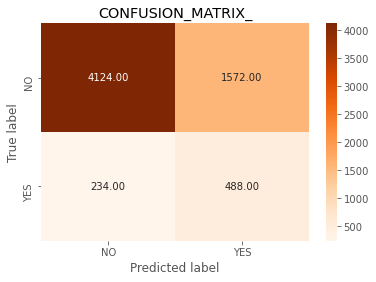


Report:
Accuracy: 0.7186039264568401
Recall: 0.6759002770083102
Precision: 0.23689320388349513
F1 Score 0.3508267433501079
auc 0.6999585654704472

ROC_AUC_CURVE: MultinomialNB()


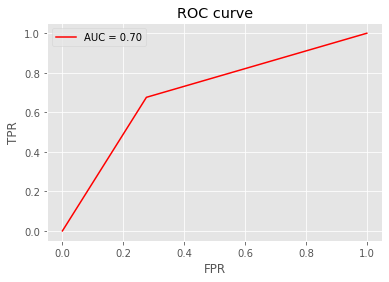

ROC_AUC_SCORE is 0.6999585654704472


In [212]:
nb=MultinomialNB()
y_hat=fit_predict(nb,x_train_m1,y_train_df1,x_test_m1)
test=evaluate(nb,y_test,y_hat)
roc_test(nb,y_test,y_hat)
scores['NB']=test

### 3.5.5. Decision Tree

DecisionTreeClassifier


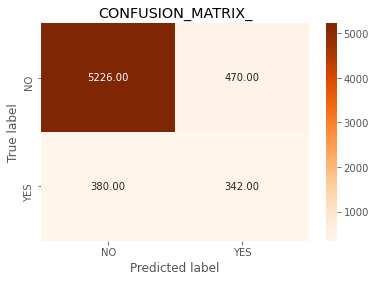


Report:
Accuracy: 0.8675599875350577
Recall: 0.47368421052631576
Precision: 0.4211822660098522
F1 Score 0.4458930899608865
auc 0.6955850827912478

ROC_AUC_CURVE: DecisionTreeClassifier()


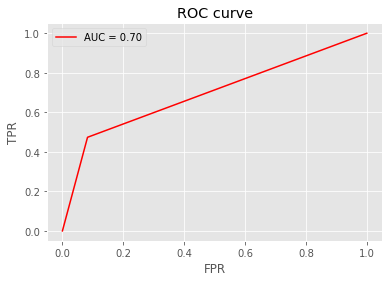

ROC_AUC_SCORE is 0.6955850827912478


In [211]:
tree=DecisionTreeClassifier()
y_hat=fit_predict(tree,x_train_std1,y_train_df1,x_test_std1)
test=evaluate(tree,y_test,y_hat)
roc_test(tree,y_test,y_hat)
scores['DT']=test

###  Summarising scores of various models

In [214]:
pd.DataFrame(scores,index=['accuracy','precision','recall','f1 score','auc'])

,knn,logR,svm,NB,DT
accuracy,0.822063,0.817077,0.830009,0.718604,0.867560
precision,0.344675,0.341069,0.368683,0.236893,0.421182
recall,0.645429,0.671745,0.717452,0.675900,0.473684
f1 score,0.449373,0.452425,0.487071,0.350827,0.445893
auc,0.744941,0.753622,0.780864,0.699959,0.695585


### Observations:
* Decision Tree gives highest accuracy & precison, but lower recall.
* NaiveBayes gives lowest value for all metrics.
* KNN & Logistic Regression are performing almost similar
* SVM gives highest recall of 71.74%, which is our requirement. All other metrics are better even accuracy is bit lesser than decision tree.
* Let us make this recall score as benchmark & try to improve by training the model with fewer features. for this, we will make use of feature selection to find top 10 features.

#### Feature Selection

In [78]:
#getting top10 features
best_features=SelectKBest(score_func=chi2,k=10)
fit=best_features.fit(x_train_m2,y_train_df2)
df_scores=pd.DataFrame(fit.scores_)
df_columns=pd.DataFrame(x_train_m2.columns)
feature_scores=pd.concat([df_columns,df_scores],axis=1)
feature_scores.columns=['Specs','Score']
feature_scores.nlargest(10,'Score')

,Specs,Score
25,contact_telephone,4576.583318
1,duration,3133.828475
27,month_5,3007.516843
21,default_0,2456.532809
35,poutcome_nonexistent,1931.445595
11,job_9,1621.609082
17,education_3,1253.382407
24,loan_yes,1217.172318
36,poutcome_success,1177.392245
9,job_7,1046.245270


In [79]:
cols=list(feature_scores.nlargest(10,'Score')['Specs'].values)
cols

['contact_telephone',
 'duration',
 'month_5',
 'default_0',
 'poutcome_nonexistent',
 'job_9',
 'education_3',
 'loan_yes',
 'poutcome_success',
 'job_7']

training report:
SVC


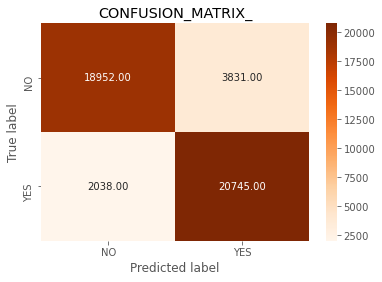


Report:
Accuracy: 0.8711978229381556
Recall: 0.9105473379274021
Precision: 0.8441162109375
F1 Score 0.8760742414324626
auc 0.8711978229381556

testing report:
SVC


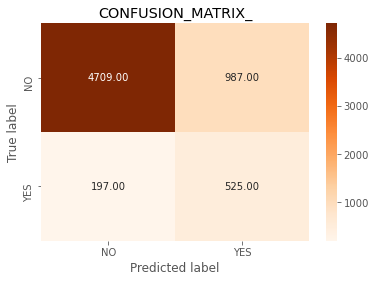


Report:
Accuracy: 0.8155188532253038
Recall: 0.7271468144044322
Precision: 0.3472222222222222
F1 Score 0.4700089525514771
auc 0.7769336600112049

ROC_AUC_CURVE: SVC(C=1)


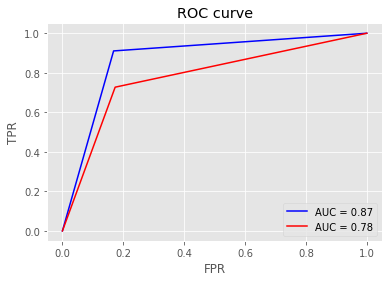

TRAIN_ROC_AUC_SCORE is 0.8711978229381556
TEST_ROC_AUC_SCORE is 0.7769336600112049


In [220]:
svm=SVC(C=1)
svm=svm.fit(x_train_m2[cols],y_train_df2)
y_hat_train=svm.predict(x_train_m2[cols])
y_hat_test=svm.predict(x_test_m2[cols])
print("training report:")
evaluate(svm,y_train_df2,y_hat_train)
print("testing report:")
evaluate(svm,y_test,y_hat_test)

auc_train,auc_test=plot_roc(svm,y_train_df2,y_hat_train,y_test,y_hat_test)

* By training with top10 features, recall of svm has slightly improved to 72.71%.Also no change in AUC.Let's now tune the hyperparameters for svm and train again to see if perfomance improves. 

In [124]:
svm=SVC()
param_grid = {'C':[0.1,1,10],
             'gamma':['scale','auto']}
grid = GridSearchCV(svm, param_grid=param_grid,cv=3,scoring='recall')
grid.fit(x_train_m2[cols],y_train_df2)
print("best_params:",grid.best_params_)
grid.cv_results_


best_params: {'C': 10, 'gamma': 'scale'}


{'mean_fit_time': array([29.34034483, 43.61582804, 30.17546574, 42.38367518, 41.21560574,
        32.14579415]),
 'std_fit_time': array([2.03147756, 2.0848024 , 3.46437111, 2.39518472, 4.48171236,
        0.85897126]),
 'mean_score_time': array([7.40108999, 8.17480087, 6.44338504, 7.32161291, 6.56761146,
        6.82761192]),
 'std_score_time': array([0.33302694, 0.21901087, 0.46318699, 0.63295048, 0.64093146,
        0.40944913]),
 'param_C': masked_array(data=[0.1, 0.1, 1, 1, 10, 10],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_gamma': masked_array(data=['scale', 'auto', 'scale', 'auto', 'scale', 'auto'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.1, 'gamma': 'scale'},
  {'C': 0.1, 'gamma': 'auto'},
  {'C': 1, 'gamma': 'scale'},
  {'C': 1, 'gamma': 'auto'},
  {'C': 10, 'gamma': 'scale'},
  {'C': 10, 'gamma': 'auto'}

training report:
SVC


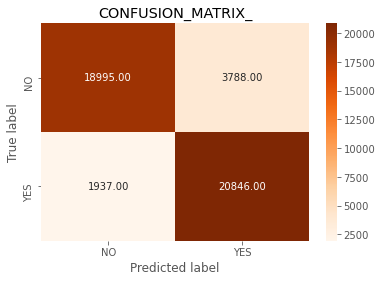


Report:
Accuracy: 0.8743580740025457
Recall: 0.914980467892727
Precision: 0.8462287894779573
F1 Score 0.8792627116856824
auc 0.874358074002546

testing report:
SVC


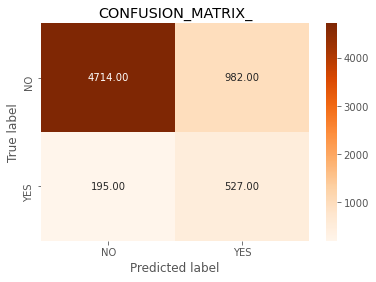


Report:
Accuracy: 0.8166095356808974
Recall: 0.7299168975069252
Precision: 0.3492379058979457
F1 Score 0.47243388614970855
auc 0.7787576060568334

ROC_AUC_CURVE: SVC(C=10)


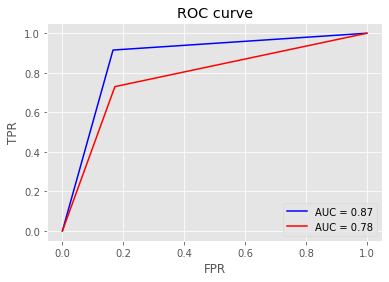

TRAIN_ROC_AUC_SCORE is 0.874358074002546
TEST_ROC_AUC_SCORE is 0.7787576060568334


In [221]:
svm=SVC(C=10,gamma='scale')
svm=svm.fit(x_train_m2[cols],y_train_df2)
y_hat_train=svm.predict(x_train_m2[cols])
y_hat_test=svm.predict(x_test_m2[cols])
print("training report:")
evaluate(svm,y_train_df2,y_hat_train)
print("testing report:")
evaluate(svm,y_test,y_hat_test)

auc_train,auc_test=plot_roc(svm,y_train_df2,y_hat_train,y_test,y_hat_test)

* Recall has slightly improved.With tuned hyperparameters,svm gives a recall score of 72.99, means model identified ~73 percent of potential customers.But This is not enough since we lost 27% of customers by misclassifying them as non-subscribers.
* Also there is no significant increase in AUC.
* We need to find better modles. We will now try out some ensemble models.

### 1.Random Forest

In [126]:
# Hyperparameter tuning :Random Forest
rfc = RandomForestClassifier()
param_grid = { 
'n_estimators':[50,100,200],
'max_features': ['auto', 'sqrt', 'log2'],
'max_depth' : [4,5,8,10],
'min_samples_split':[100,200,300],
'criterion' :['gini', 'entropy']
             }
grid = GridSearchCV(rfc, param_grid=param_grid)
grid.fit(x_train_m2[cols],y_train_df2)
print("best_params:",grid.best_params_)
grid.cv_results_


best_params: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 100, 'n_estimators': 200}


{'mean_fit_time': array([0.80444603, 1.57148981, 3.10317755, 0.78924503, 1.54568849,
        3.08177619, 0.77844448, 1.54668851, 3.06857557, 0.77864451,
        1.58309059, 3.11897831, 0.78704495, 1.61209221, 3.08257632,
        0.77824445, 1.55308881, 3.10477772, 0.7838448 , 1.55148892,
        3.13877959, 0.77864451, 1.55748901, 3.11937842, 0.78384495,
        1.6020916 , 3.48559942, 0.98905659, 1.96071215, 3.89902306,
        0.98605628, 1.93951097, 3.87742176, 0.97445574, 1.91570959,
        3.86842122, 0.97825589, 1.92711024, 3.71501255, 0.86484947,
        1.70669765, 3.43759665, 0.86784964, 1.72589874, 3.44939723,
        0.87565017, 1.73089905, 3.43019624, 0.86344938, 1.71669827,
        3.80021739, 0.9812561 , 1.94291115, 3.83061914, 1.25427189,
        2.45854053, 4.90348039, 1.21486945, 2.41253805, 4.81867557,
        1.18966804, 2.40973792, 4.81407537, 1.23667078, 2.43513927,
        4.91308093, 1.22066979, 2.43193913, 4.84327707, 1.24127102,
        2.40533757, 4.81027503,

training report:
Accuracy: 0.9109204231225037
Recall: 0.9490848439626037
Precision: 0.8817796264578746
F1 Score 0.9141951167952649


training report:
Accuracy: 0.8195699594889374
Recall: 0.6800554016620498
Precision: 0.346262341325811
F1 Score 0.45887850467289726

ROC_AUC_CURVE: RandomForestClassifier()


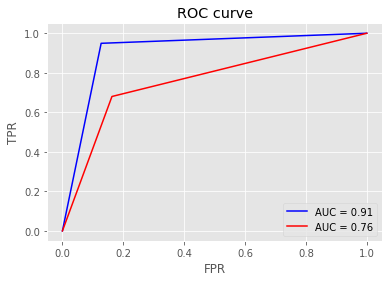

TRAIN_ROC_AUC_SCORE is 0.9109204231225037
TEST_ROC_AUC_SCORE is 0.7586548075725978


In [224]:
y_hat_train=rfc.predict(x_train_m2[cols])
y_hat_test=rfc.predict(x_test_m2[cols])

#evaluating training & test results.
print("training report:")
get_metrics(rfc,y_train_df2,y_hat_train)
print("\ntraining report:")
get_metrics(rfc,y_test,y_hat_test)

auc_train,auc_test=plot_roc(rfc,y_train_df2,y_hat_train,y_test,y_hat_test)

* Randomforest estimator with 200 trees and maximum depth 10, doesn't make much improvement in the recall rate. Also difference between train & test incresed, implying overfitting. Now let's try out lesser no. of trees and check the results.

In [160]:
rfc = RandomForestClassifier()
param_grid = { 
'n_estimators':[40,50,60,70],
'max_features': ['auto', 'sqrt', 'log2'],
'max_depth' : [4,5,8,10],
'min_samples_split':[500,1000,2000],
'criterion' :['gini', 'entropy']
             }
grid = GridSearchCV(rfc, param_grid=param_grid)
grid.fit(x_train_m2[cols],y_train_df2)
print("best_params:",grid.best_params_)
grid.cv_results_


best_params: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 500, 'n_estimators': 50}


{'mean_fit_time': array([0.71404076, 0.79324527, 0.93525357, 1.08546209, 0.62743602,
        0.74984288, 0.93465347, 1.07606158, 0.62243552, 0.75964346,
        0.91965261, 1.05226016, 0.6454371 , 0.76824393, 0.92985325,
        1.11906404, 0.60723491, 0.80064578, 0.96725535, 1.09266257,
        0.62143564, 0.77984462, 0.91605239, 1.07226138, 0.62003541,
        0.77964458, 0.94645405, 1.2814733 , 0.69343967, 0.89165096,
        1.08486209, 1.23707066, 0.68803945, 0.87565012, 1.03605928,
        1.22326994, 0.76264367, 0.98745646, 1.19906855, 1.35127726,
        0.79844565, 0.97525582, 1.14026518, 1.35267749, 0.7394423 ,
        0.94305387, 1.11226358, 1.32867603, 0.8060461 , 1.01025782,
        1.15846624, 1.36267791, 0.76884398, 0.95565457, 1.17706723,
        1.35227742, 0.75964355, 0.9368536 , 1.09286237, 1.31047497,
        0.8112464 , 0.98505635, 1.18006749, 1.37707877, 0.77284427,
        0.96945543, 1.15786624, 1.32347584, 0.76404376, 0.94345403,
        1.11566381, 1.30787468,

training report:
Accuracy: 0.8771452398718342
Recall: 0.9144537593819954
Precision: 0.8509578074582363
F1 Score 0.8815639148648077


testing report:
Accuracy: 0.8234652539732004
Recall: 0.739612188365651
Precision: 0.36105476673427994
F1 Score 0.4852339845524761

ROC_AUC_CURVE: RandomForestClassifier(criterion='entropy', max_depth=10, max_features='sqrt',
                       min_samples_split=500, n_estimators=50)


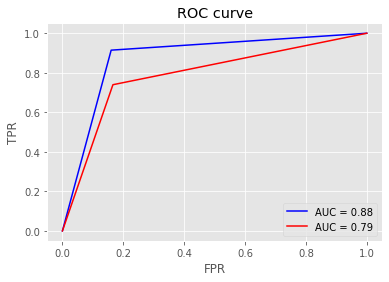

TRAIN_ROC_AUC_SCORE is 0.8771452398718345
TEST_ROC_AUC_SCORE is 0.7868531447446232


In [225]:
#fitting random forest classifier
rfc=RandomForestClassifier(criterion='entropy', max_depth= 10, max_features= 'sqrt', min_samples_split=500, n_estimators= 50)
rfc.fit(x_train_m2[cols],y_train_df2)
y_hat_train=rfc.predict(x_train_m2[cols])
y_hat_test=rfc.predict(x_test_m2[cols])

#evaluating training & test results.
print("training report:")
get_metrics(rfc,y_train_df2,y_hat_train)
print("\ntesting report:")
get_metrics(rfc,y_test,y_hat_test)

auc_train,auc_test=plot_roc(rfc,y_train_df2,y_hat_train,y_test,y_hat_test)

* With lesser no.of estimators  model gives a recall score of 74.23.Train-test auc difference also reduced slightly. Lets try to optimize parameters better by crossvalidating with individual parameters.we will look for no. of estimators keeping all other parameters constant.

In [176]:
rfc = RandomForestClassifier(criterion='entropy', max_depth= 10, max_features= 'sqrt', min_samples_split=500)
param_grid = { 
'n_estimators':[30,40,50,60,70]
             }
grid = GridSearchCV(rfc, param_grid=param_grid)
grid.fit(x_train_m2[cols],y_train_df2)
print("best_params:",grid.best_params_)

best_params: {'n_estimators': 60}


In [179]:
rfc = RandomForestClassifier(n_estimators=60,criterion='entropy', max_depth= 10, max_features= 'sqrt')
param_grid = { 
     'min_samples_split':[100,200,500,1000,2000]
             }
grid = GridSearchCV(rfc, param_grid=param_grid)
grid.fit(x_train_m2[cols],y_train_df2)
print("best_params:",grid.best_params_)

best_params: {'min_samples_split': 100}


In [181]:
rfc = RandomForestClassifier(criterion='entropy', max_depth= 10, max_features= 'sqrt', min_samples_split=100,n_estimators=50)
param_grid = { 
            'max_depth':[8,10,12,14]
             }
grid = GridSearchCV(rfc, param_grid=param_grid)
grid.fit(x_train_m2[cols],y_train_df2)
print("best_params:",grid.best_params_)

best_params: {'max_depth': 14}


training report:
Accuracy: 0.883399903436773
Recall: 0.9202914453759382
Precision: 0.8570552648790059
F1 Score 0.88754841577243


testing report:
Accuracy: 0.8251791835462761
Recall: 0.7146814404432132
Precision: 0.36033519553072624
F1 Score 0.47910863509749296

ROC_AUC_CURVE: RandomForestClassifier(criterion='entropy', max_depth=14, max_features='sqrt',
                       min_samples_split=100, n_estimators=60)


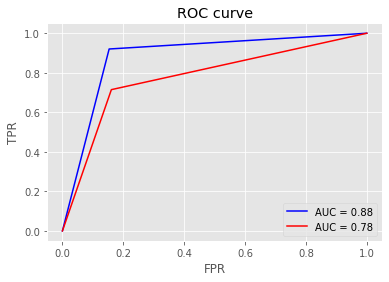

TRAIN_ROC_AUC_SCORE is 0.883399903436773
TEST_ROC_AUC_SCORE is 0.7769334168508201


In [226]:
#fitting random forest classifier
rfc=RandomForestClassifier(criterion='entropy', max_depth= 14, max_features= 'sqrt', min_samples_split=100, n_estimators= 60)
rfc.fit(x_train_m2[cols],y_train_df2)
y_hat_train=rfc.predict(x_train_m2[cols])
y_hat_test=rfc.predict(x_test_m2[cols])

#evaluating training & test results.
print("training report:")
get_metrics(rfc,y_train_df2,y_hat_train)
print("\ntesting report:")
get_metrics(rfc,y_test,y_hat_test)

auc_train,auc_test=plot_roc(rfc,y_train_df2,y_hat_train,y_test,y_hat_test)

* Model Recall score has reduced to 71.46. So we will fix at previous random forest model, which gave ~74% recall score. Now lets try out gradient boosting classifier and check the result.

In [163]:
gbdt = GradientBoostingClassifier()
param_grid = {
'learning_rate':[0.01,0.1,1],
'n_estimators':[40,60,80],
'max_features': ['auto', 'sqrt', 'log2'],
'max_depth' : [4,5,8,10],
'min_samples_split':[500,1000,2000]
             }
grid = GridSearchCV(gbdt,param_grid=param_grid)
grid.fit(x_train_m2[cols],y_train_df2)
print("best_params:",grid.best_params_)
grid.cv_results_


best_params: {'learning_rate': 0.1, 'max_depth': 10, 'max_features': 'auto', 'min_samples_split': 500, 'n_estimators': 80}


{'mean_fit_time': array([1.66469517, 2.49614282, 3.27358727, 1.62269268, 2.44714003,
        3.21858406, 1.60669198, 2.37533588, 3.31258941, 0.88765087,
        1.30507469, 1.75090022, 0.87064981, 1.3042747 , 1.75370021,
        0.86224933, 1.27127266, 1.69569693, 0.87484999, 1.32247562,
        1.74029942, 0.85924911, 1.30107427, 1.72329855, 0.85044861,
        1.28067317, 1.65369463, 2.28113046, 3.50860071, 4.54846015,
        2.22732739, 3.34219112, 4.39245119, 2.16512394, 3.21738405,
        4.22344165, 1.1976685 , 1.79910288, 2.40353746, 1.19426842,
        1.76970124, 2.32273293, 1.11946406, 1.69589701, 2.24712853,
        1.19726858, 1.8127037 , 2.44573984, 1.19526839, 1.79070244,
        2.31233225, 1.12246428, 1.70669761, 2.27132993, 3.36419249,
        4.9172812 , 6.54697452, 2.91596675, 4.3662498 , 5.81133242,
        2.71935554, 3.92642455, 4.63986535, 1.58469067, 2.4221385 ,
        3.20638337, 1.41708102, 2.10392046, 2.81396093, 1.23667073,
        1.87530727, 2.46754117,

In [187]:
gbdt=GradientBoostingClassifier(learning_rate=0.1,n_estimators=80, max_depth=10,min_samples_split=500, max_features= 'auto')
gbdt.fit(x_train_m2[cols],y_train_df2)
y_hat_train=gbdt.predict(x_train_m2[cols])
y_hat_test=gbdt.predict(x_test_m2[cols])

#evaluating training & test results.
print("training report:")
get_metrics(gbdt,y_train_df2,y_hat_train)
print("\ntesting report:")
get_metrics(gbdt,y_test,y_hat_test)


training report:
Accuracy: 0.8909274459026467
Recall: 0.9328007725058157
Precision: 0.8607184804179661
F1 Score 0.8953111176644057


testing report:
Accuracy: 0.8267373013399814
Recall: 0.7105263157894737
Precision: 0.3622881355932203
F1 Score 0.4798877455565949



* Recall rate has reduced further with GBDT, So we will go with Random Forest Classifier with tuned parameters.

training report:
RandomForestClassifier


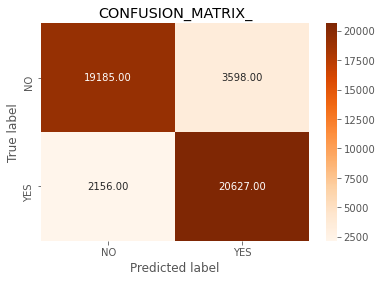


Report:
Accuracy: 0.8737216345520783
Recall: 0.9053680375718738
Precision: 0.8514757481940144
F1 Score 0.8775953029271613
auc 0.8737216345520782

testing report:
RandomForestClassifier


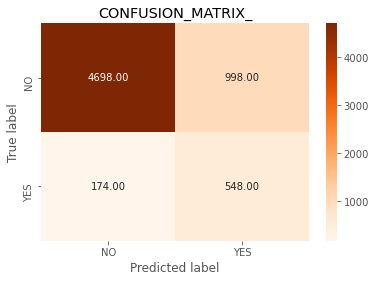


Report:
Accuracy: 0.81738859457775
Recall: 0.7590027700831025
Precision: 0.35446313065976714
F1 Score 0.48324514991181655
auc 0.7918960479628995

ROC_AUC_CURVE: RandomForestClassifier(criterion='entropy', max_depth=10, max_features='sqrt',
                       min_samples_split=500, n_estimators=50)


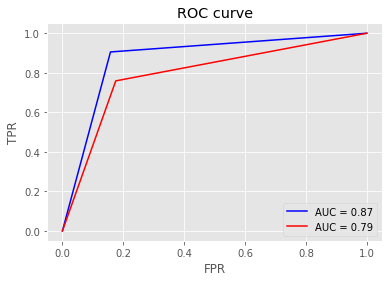

TRAIN_ROC_AUC_SCORE is 0.8737216345520782
TEST_ROC_AUC_SCORE is 0.7918960479628995


In [81]:
#fitting random forest classifier with optimum parameters
rfc_final=RandomForestClassifier(criterion='entropy', max_depth= 10, max_features= 'sqrt', min_samples_split=500, n_estimators= 50)
rfc_final.fit(x_train_m2[cols],y_train_df2)
y_hat_train=rfc_final.predict(x_train_m2[cols])
y_hat_test=rfc_final.predict(x_test_m2[cols])

print("training report:")
evaluate(rfc_final,y_train_df2,y_hat_train)
print("testing report:")
evaluate(rfc_final,y_test,y_hat_test)
auc_train,auc_test=plot_roc(rfc_final,y_train_df2,y_hat_train,y_test,y_hat_test)

### Make Predictions

In [100]:
# Predictions on test_data #predict probability of belonging to each class.
y_hat_prob=[prob[1] for prob in rfc_final.predict_proba(x_test_m2[cols])]
y_hat_prob[:5]

[0.01821288223751403,
 0.9122446576921078,
 0.07446098164512717,
 0.7399123275288462,
 0.4120407756454086]

In [103]:
predictions=pd.DataFrame({'prediction':y_hat_test,'probability_1':y_hat_prob})
predictions.head(10)

,prediction,probability_1
0,0,0.018213
1,1,0.912245
2,0,0.074461
3,1,0.739912
4,0,0.412041
5,0,0.006718
6,1,0.506742
7,0,0.012568
8,0,0.069266
9,0,0.149190


In [104]:
predictions['prediction'].value_counts()

0    4872
1    1546
Name: prediction, dtype: int64

In [106]:
predictions.sort_values(by='probability_1',ascending=False,inplace=False)

,prediction,probability_1
5929,1,0.961504
3491,1,0.961504
1540,1,0.961504
22,1,0.960616
5619,1,0.960616
...,...,...
3927,0,0.000643
2885,0,0.000643
3958,0,0.000643
2824,0,0.000643


###  Observations & Summary:
* RandomForest classifier with optimum paramters gives the best results by predicts potential customers with 75.90% recall rate,AUC score of 0.79 & Accuracy of 82%.
* This means that our model is successful in predicting ~74% of total customers those are willing to subscribe for term deposit plan correctly & 82% of total predictions are correct(including positive & negative predictions)
* The 0.79 AUC score on test data ensures that model is capable of classifyig subscribing customers & non-subscribing customers with 79% probability of correct classification.
* The model is successful in predicting ~76% of potential customers. Hence targetting the customers predicted by the model for marketing campaigns will result in positive response by 3/4th of the total targetted customers, thus making most out the marketing efforts & reducing cost of marketing.

* In our testdata 1546 customers are predicted to be potential customers. Give preference to these customers would help marketing a lot .
* Dataframe sorted in the order of probability of subscription is useful in finding customer ids of highest probability of subscribing to term deposit & targeting those customers, thus making marketing procedures more efficient.
* Model can be improved further by training with more data.

===============================================================================================================================

In [84]:
#==============================================================================================================================#
# Creating a pickle file for the classifier #saving model for future use.
filename = r'E:\projects_2020\Bank_prediction_files\bank_prediction_rfc.pkl'
pickle.dump(rfc_final, open(filename, 'wb'))
#==============================================================================================================================#